# Mask of border

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import blobfile as bf
import PIL


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    # print(imgs.shape)
    for i, img in enumerate(imgs):
        img = img.detach()
        # img = F.to_pil_image(img)
        img = Image.fromarray(img)
        # print(np.max(img), np.min(img), np.mean(img))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def load_image(path):
    with bf.BlobFile(path, "rb") as f:
        pil_image = PIL.Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert("RGB")
    return pil_image

def face_segment(segment_part, img_name):
    # print(self.kwargs.keys())
    # print(self.kwargs['in_image_for_cond'].keys())
    # exit()
    face_segment_anno = load_image(img_name)
    
    face_segment_anno = np.array(face_segment_anno)
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_cloth':
        seg_m = cloth
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_hat':
        seg_m = hat
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

def create_image_grid(images, n_rows=1, text_labels=[]):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)

    # Add text labels to the grid
    img_height, img_width = images[0].shape[:2]
    for i, text_label in enumerate(text_labels):
        # plt.text((i % n_cols) * img_width, (i // n_cols) * img_height, text_label, color='red', fontsize=12)
        if isinstance(text_label, str):
            plt.text((i % n_cols) * img_width, -2, text_label, color='red', fontsize=20)
        else:
            plt.text((i % n_cols) * img_width, -2, f'{float(text_label):.5f}', color='red', fontsize=20)

    return grid_image

  0%|          | 0/13 [00:00<?, ?it/s]

Max-Min of load image:  255 2
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 5
Grey Image Shape:  (128, 128, 1)


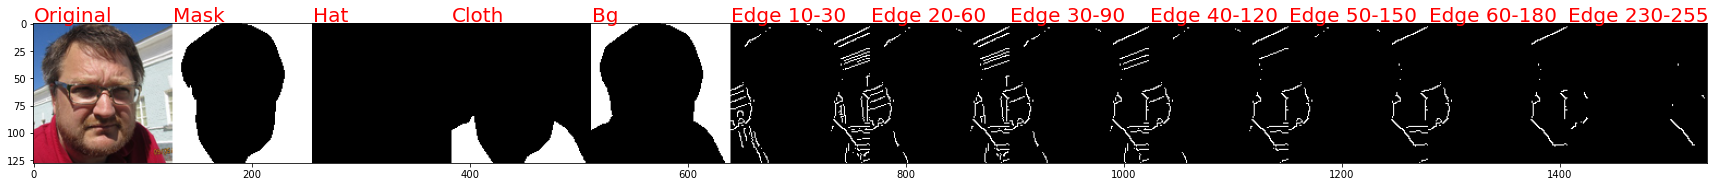

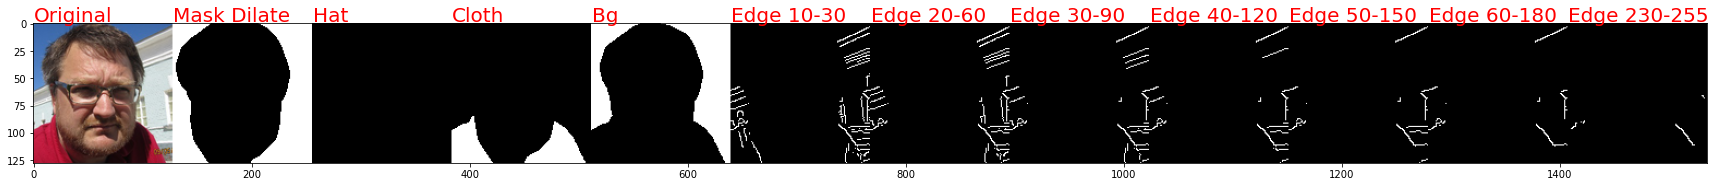

  8%|▊         | 1/13 [00:00<00:04,  2.55it/s]

Max-Min of load image:  255 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 6
Grey Image Shape:  (128, 128, 1)


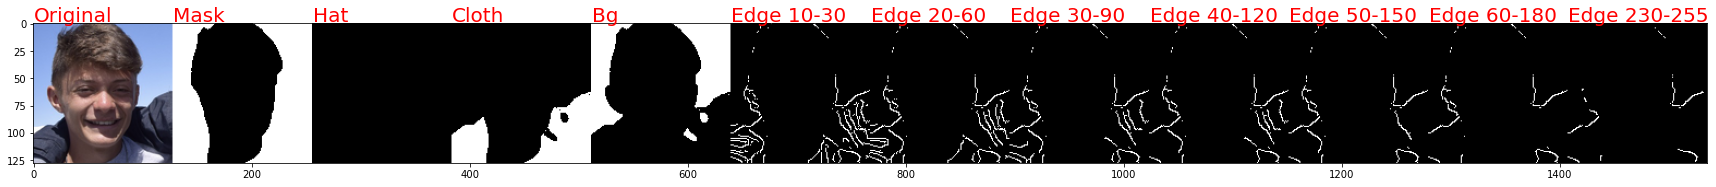

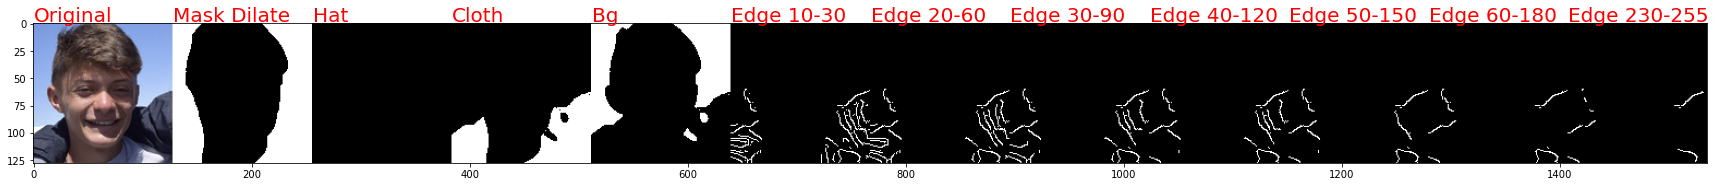

 15%|█▌        | 2/13 [00:00<00:03,  3.05it/s]

Max-Min of load image:  255 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 0
Grey Image Shape:  (128, 128, 1)


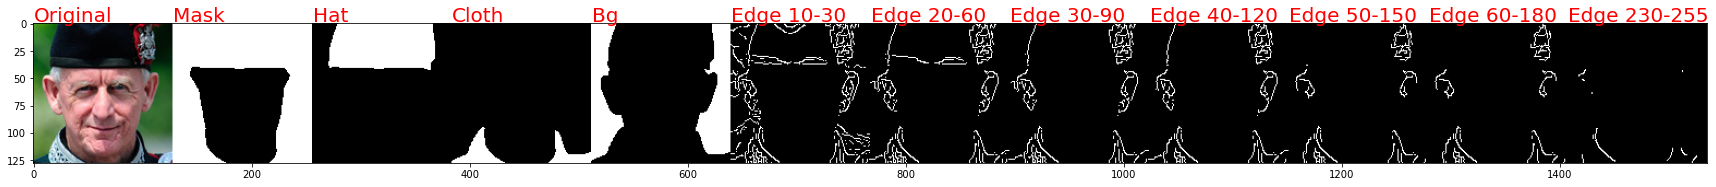

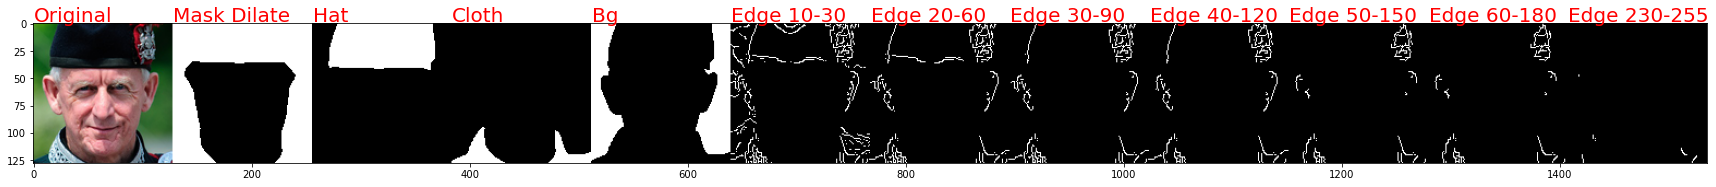

 23%|██▎       | 3/13 [00:00<00:03,  3.24it/s]

Max-Min of load image:  255 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 2
Grey Image Shape:  (128, 128, 1)


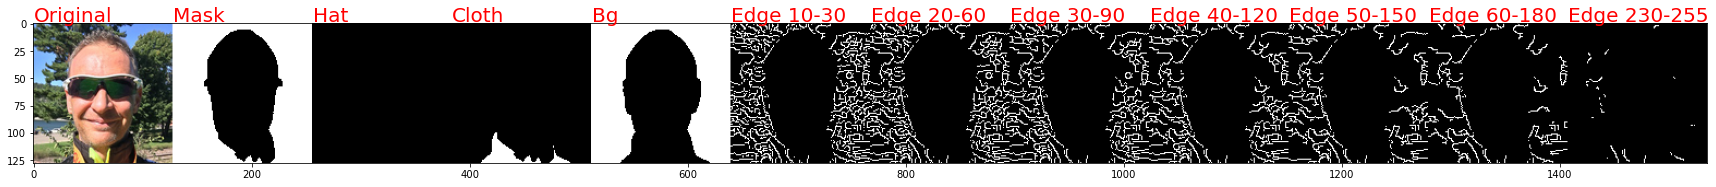

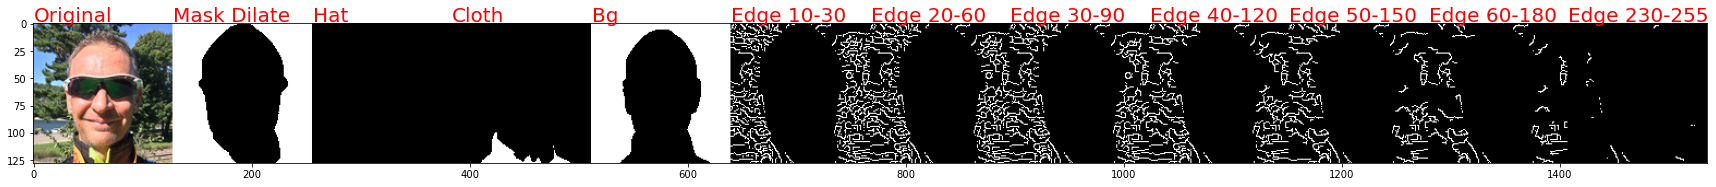

 31%|███       | 4/13 [00:01<00:02,  3.32it/s]

Max-Min of load image:  255 8
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 17
Grey Image Shape:  (128, 128, 1)


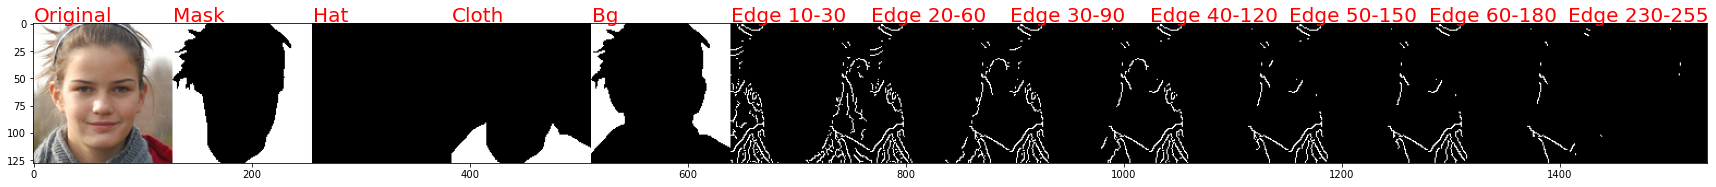

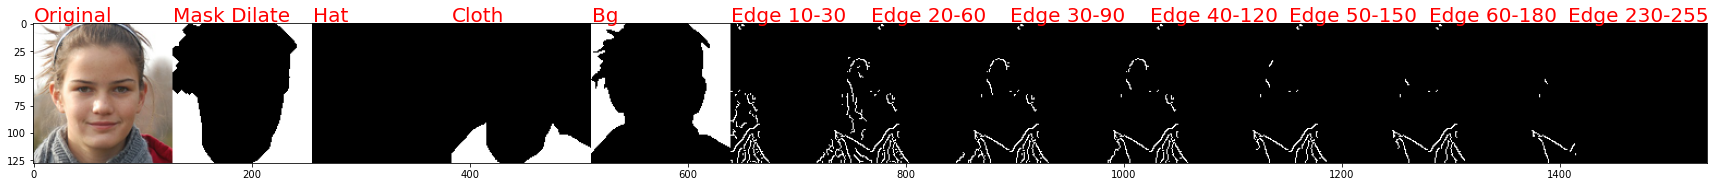

 38%|███▊      | 5/13 [00:01<00:02,  3.38it/s]

Max-Min of load image:  255 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 0
Grey Image Shape:  (128, 128, 1)


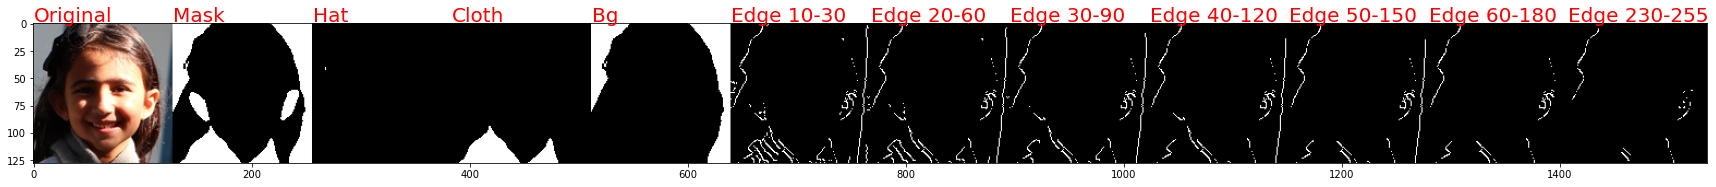

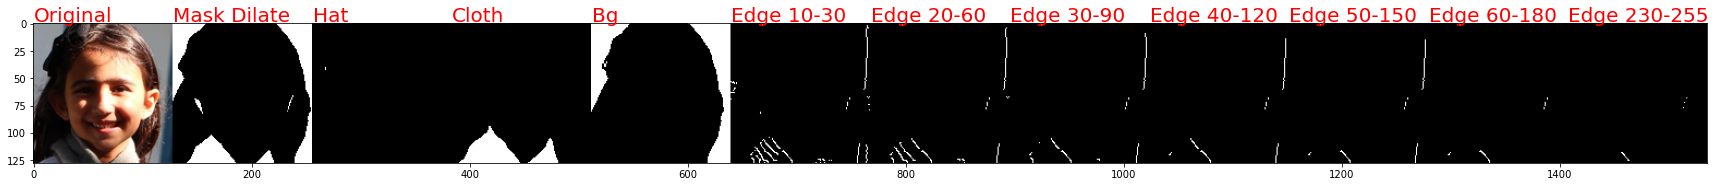

 46%|████▌     | 6/13 [00:01<00:02,  3.43it/s]

Max-Min of load image:  255 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 0
Grey Image Shape:  (128, 128, 1)


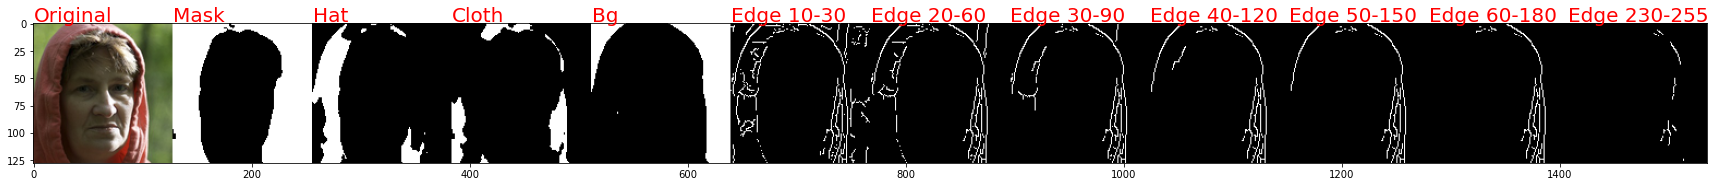

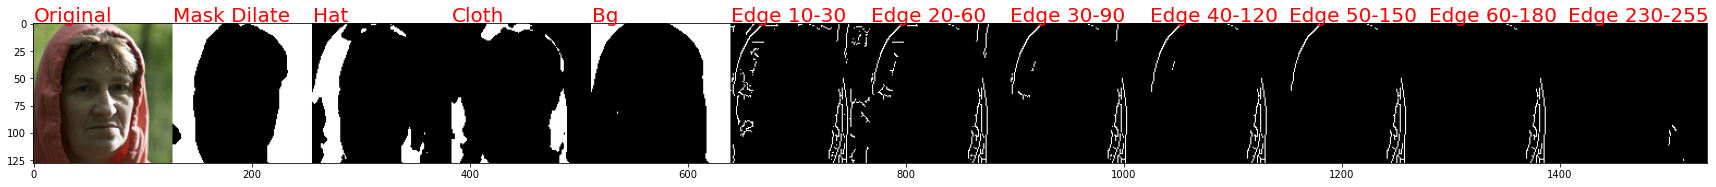

 54%|█████▍    | 7/13 [00:02<00:01,  3.46it/s]

Max-Min of load image:  252 6
Img Shape:  (128, 128, 3)
Max-Min of grey image:  244 10
Grey Image Shape:  (128, 128, 1)


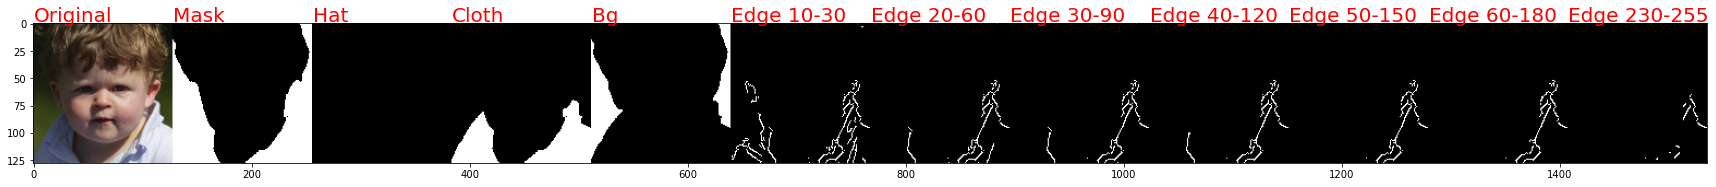

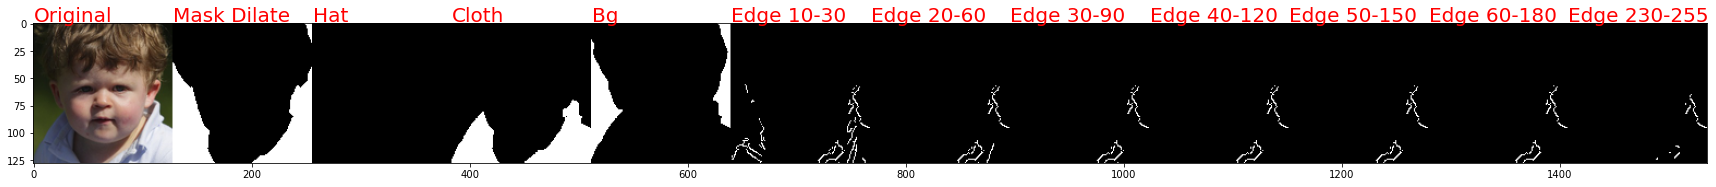

 62%|██████▏   | 8/13 [00:02<00:01,  3.14it/s]

Max-Min of load image:  255 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  250 5
Grey Image Shape:  (128, 128, 1)


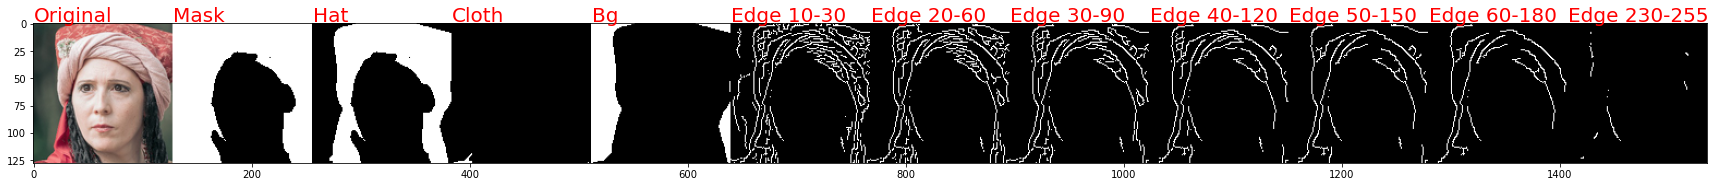

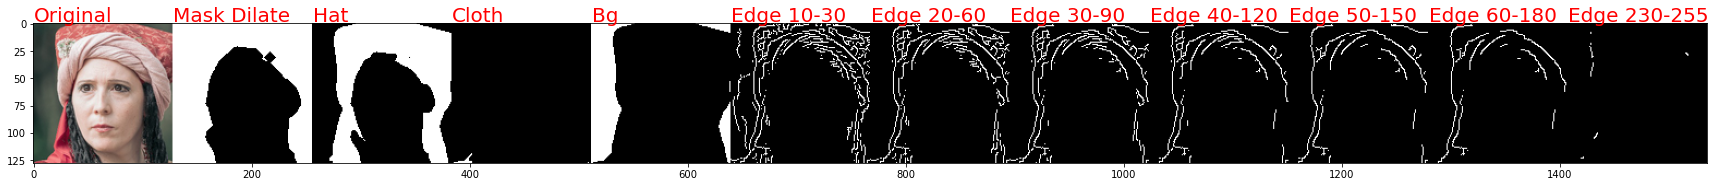

 69%|██████▉   | 9/13 [00:02<00:01,  3.24it/s]

Max-Min of load image:  255 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 4
Grey Image Shape:  (128, 128, 1)


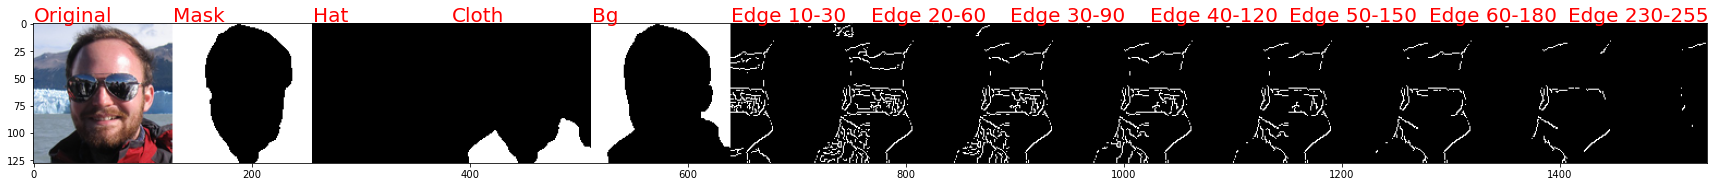

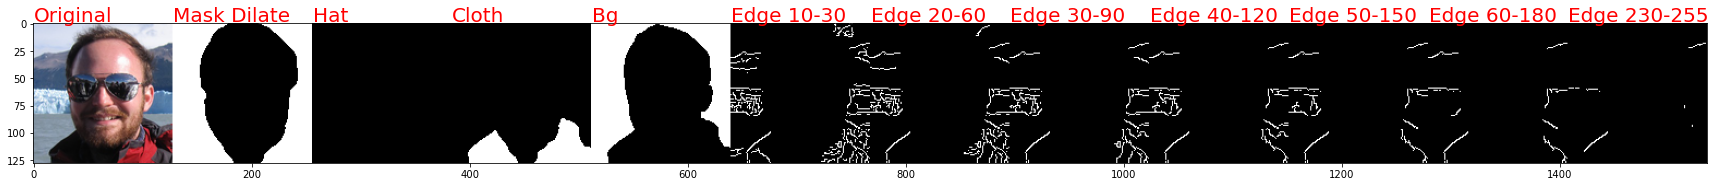

 77%|███████▋  | 10/13 [00:03<00:00,  3.33it/s]

Max-Min of load image:  255 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 0
Grey Image Shape:  (128, 128, 1)


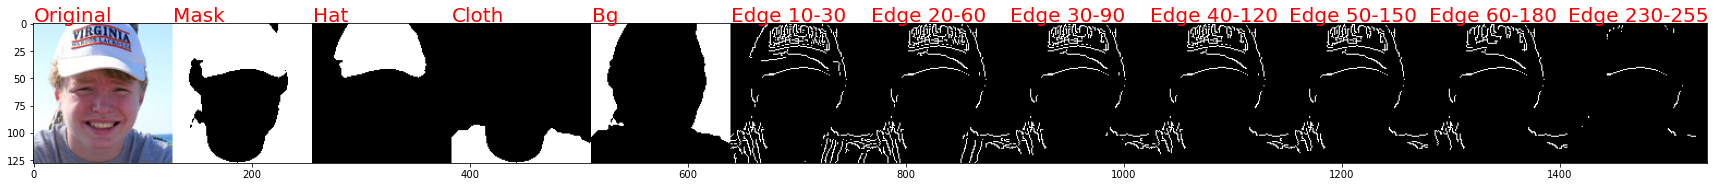

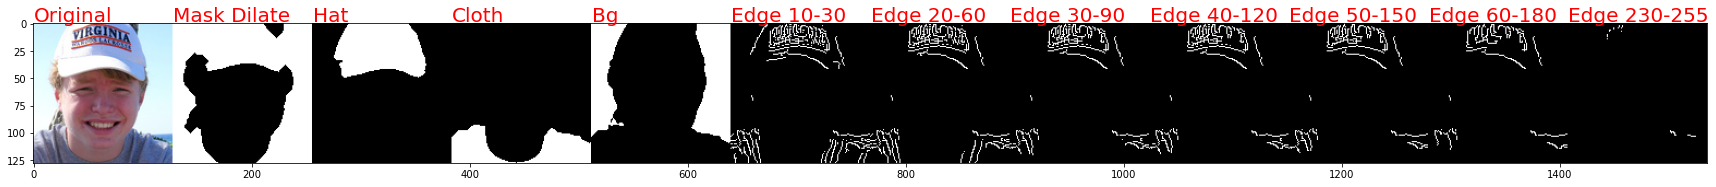

 85%|████████▍ | 11/13 [00:03<00:00,  3.34it/s]

Max-Min of load image:  255 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  255 0
Grey Image Shape:  (128, 128, 1)


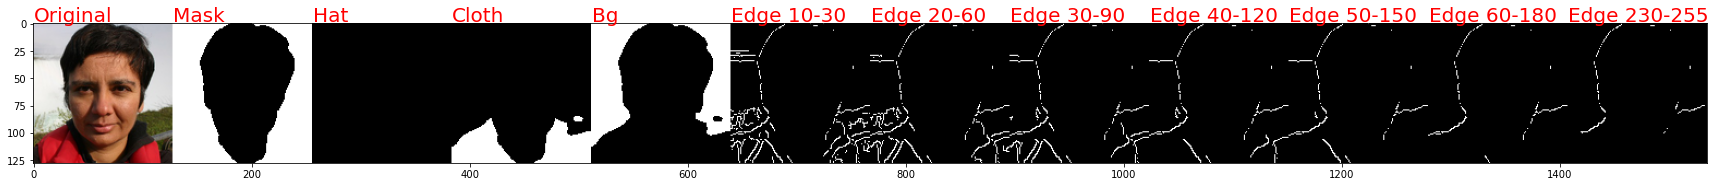

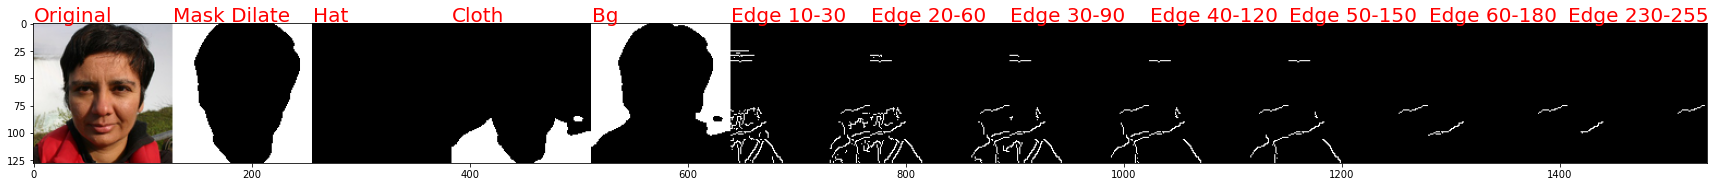

 92%|█████████▏| 12/13 [00:03<00:00,  3.38it/s]

Max-Min of load image:  234 0
Img Shape:  (128, 128, 3)
Max-Min of grey image:  230 0
Grey Image Shape:  (128, 128, 1)


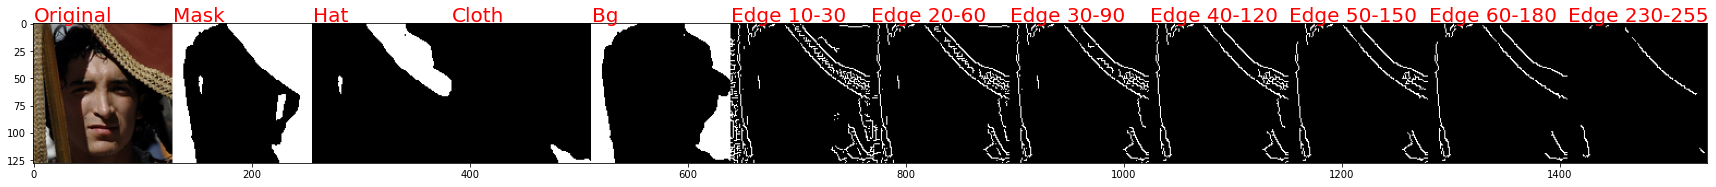

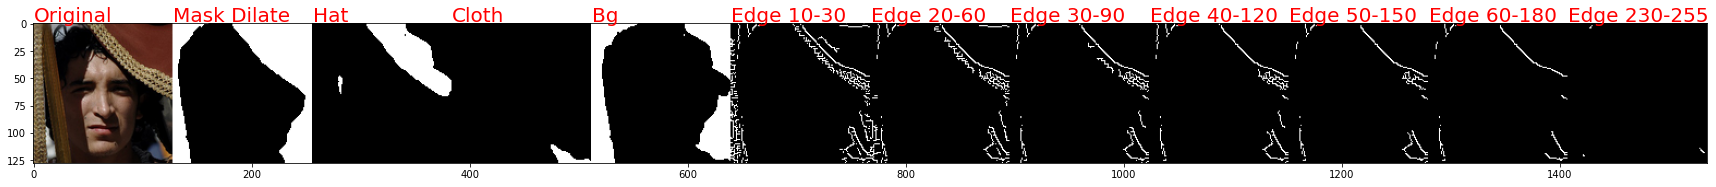

100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


In [33]:
import torch as th
import numpy as np
from scipy import ndimage
import pickle
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import tqdm
import os, glob
import cv2

set_ = 'valid'
img_file = glob.glob(f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/*.jpg")
img_size = 256
import cv2
from PIL import Image
import blobfile as bf

resolution = 128
mode = 'L'
img_file = [f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/69398.jpg", 
            f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/67400.jpg",
            f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/60208.jpg",
            f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/69257.jpg",
            f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/65128.jpg",
            f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/65169.jpg",
            f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/66646.jpg",
            f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/69161.jpg",
            f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/65203.jpg",] + img_file

img_file = [f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/62999.jpg", 
            f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/65203.jpg",] + img_file

img_file = [
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/63849.jpg", 
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/67641.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/64889.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/64240.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/60704.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/62369.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/65128.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/68105.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/62889.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/69128.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/69878.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/64691.jpg",
    f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/63919.jpg",
]
for i, path in enumerate(tqdm.tqdm(img_file)):
    name = path.split('/')[-1].split('.')[0]
    with bf.BlobFile(path, "rb") as f:
        pil_image = Image.open(f)
        pil_image.load()
    
    
    path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/face_segment/{set_}/anno/anno_{name}.png"
    mask = face_segment('canny_edge_bg_mask', path)
    bg = face_segment('faceseg_bg', path)
    cloth = face_segment('faceseg_cloth', path)
    hat = face_segment('faceseg_hat', path)
    mask = cv2.resize(mask.astype(np.uint8), (resolution, resolution), interpolation=cv2.INTER_NEAREST)
    mask = mask[..., 0:1]
    mask_dilate = 1-ndimage.binary_dilation(1-mask, iterations=5).astype(mask.dtype)
    bg = cv2.resize(bg.astype(np.uint8), (resolution, resolution), interpolation=cv2.INTER_NEAREST)
    cloth = cv2.resize(cloth.astype(np.uint8), (resolution, resolution), interpolation=cv2.INTER_NEAREST)
    hat = cv2.resize(hat.astype(np.uint8), (resolution, resolution), interpolation=cv2.INTER_NEAREST)

    pil_image = pil_image.resize((resolution, resolution), PIL.Image.ANTIALIAS)
    grey_img = np.array(pil_image.convert('L'))
    img = grey_img[..., np.newaxis]
    
    print("Max-Min of load image: ", np.max(np.array(pil_image)), np.min(np.array(pil_image)))
    print("Img Shape: ", np.array(pil_image).shape)
    print("Max-Min of grey image: ", np.max(grey_img), np.min(grey_img))
    print("Grey Image Shape: ", img.shape)
    
    edges = []
    edges_dilate = []
    ratio = 3
    # for thres in [[153, 204], [0, 255], [128, 255], [64, 128], [240, 255]]:
    for thres in [[10, 10*ratio], [20, 20*ratio], [30, 30*ratio], [40, 40*ratio], [50, 50*ratio], [60, 60*ratio], [245, 255]]:
        e = cv2.blur(img, (5, 5))
        e = cv2.Canny(e, thres[0], thres[1])
        e = e[..., np.newaxis]
        ed = e * mask_dilate
        ed = np.repeat(ed, 3, axis=-1)
        edges_dilate.append(ed)
        e = e * mask
        e = np.repeat(e, 3, axis=-1)
        edges.append(e)
    
    fig = plt.figure(figsize=(30, 30))
    plt.imshow(create_image_grid([np.array(pil_image), np.repeat(mask, 3, -1)*255, hat*255, cloth*255, bg*255] + edges, 
                                 text_labels=['Original', 'Mask', 'Hat', 'Cloth', 'Bg', 'Edge 10-30', 'Edge 20-60', 'Edge 30-90', 'Edge 40-120', 'Edge 50-150', 'Edge 60-180', 'Edge 230-255']))
    plt.show()

    fig = plt.figure(figsize=(30, 30))
    plt.imshow(create_image_grid([np.array(pil_image), np.repeat(mask_dilate, 3, -1)*255, hat*255, cloth*255, bg*255] + edges_dilate, 
                                 text_labels=['Original', 'Mask Dilate', 'Hat', 'Cloth', 'Bg', 'Edge 10-30', 'Edge 20-60', 'Edge 30-90', 'Edge 40-120', 'Edge 50-150', 'Edge 60-180', 'Edge 230-255']))
    plt.show()
    if i == 30: break